# Capacity Expansion Planning with `pypsa`

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

:::{note}
Also in this tutorial, you might want to refer to the PyPSA documentation: https://pypsa.readthedocs.io.
:::

## From electricity market modelling to capacity expansion planning

Review the problem formulation of the electricity market model. Below you can find an adapted version
where the capacity limits have been promoted to **decision variables** with corresponding terms
in the *objective function* and *new constraints for their expansion limits* (e.g. wind and solar potentials). This is known as **capacity expansion problem**.

\begin{equation*}
    \min_{g,e,f,G,E,F} \quad \sum_{i,s,t} w_t o_{s} g_{i,s,t} + \sum_{i,s} c_sG_{i,s}  + c_{r,\text{dis/charge}}G_{i,r, \text{dis/charge}} +   c_{r}E_{i,r}  + c_\ell F_{\ell}
  \end{equation*}
such that
  \begin{align*}
    d_{i,t} &= \sum_s g_{i,s,t}  - \sum_\ell K_{i\ell} f_{\ell,t}   & \text{energy balance} \\
    0 &\leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s} & \text{generator limits}\\
    0 & \leq g_{i,r,t,\text{dis/charge}} \leq G_{i,r,\text{dis/charge}}& \text{storage dis/charge limits} \\
    0 & \leq e_{i,r,t} \leq E_{r} & \text{storage energy limits} \\ 
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{r}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{r}} g_{i,r,t,\text{discharge}} & \text{storage consistency} \\
    -F_\ell &\leq f_{\ell,t} \leq F_\ell  & \text{line limits} \\
    0 &= \sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL} \\
        \underline{G}_{i,s} & \leq G_{i,s} \leq \overline{G}_{i,s} & \text{generator capacity expansion limits} \\
    \underline{G}_{i,r, \text{dis/charge}} & \leq G_{i,r, \text{dis/charge}} \leq \overline{G}_{i,r, \text{dis/charge}} & \text{storage power capacity expansion limits} \\
    \underline{E}_{i,r} & \leq E_{i,r} \leq \overline{E}_{i,r} & \text{storage energy expansion limits} \\
    \underline{F}_{\ell} & \leq F_{\ell} \leq \overline{F}_{\ell} & \text{line capacity expansion limits}
  \end{align*}

**New decision variables for capacity expansion planning:**

- $G_{i,s}$ is the generator capacity at bus $i$, technology $s$,
- $F_{\ell}$ is the transmission capacity of line $\ell$,
- $G_{i,r,\text{dis-/charge}}$ denotes the charge and discharge capacities of storage unit $r$ at bus $i$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$ and time step $t$.

**New parameters for capacity expansion planning:**

- $c_{\star}$ is the capital cost of technology $\star$ at bus $i$
- $w_t$ is the weighting of time step $t$ (e.g. number of hours it represents)
- $\underline{G}_\star, \underline{F}_\star, \underline{E}_\star$ are the minimum capacities per technology and location/connection.
- $\underline{G}_\star, \underline{F}_\star, \underline{E}_\star$ are the maximum capacities per technology and location.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

First things first! We need a few packages for this tutorial:

In [277]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [278]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0,1])

In [279]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [280]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [281]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the short-term marginal generation costs (STMGC, €/MWh):

In [282]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [283]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [284]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

## Loading time series data

We are also going to need some time series for wind, solar and load. For now, we are going to recycle the time series we used at the beginning of the course. They are given for Germany in the year 2015.

In [285]:
url = "https://raw.githubusercontent.com/fneum/data-science-for-esm/main/data-science-for-esm/time-series-lecture-2.csv"
ts = pd.read_csv(url, index_col=0, parse_dates=True)

In [286]:
ts.head(3)

,load,onwind,offwind,solar,prices
2015-01-01 00:00:00,41.151,0.1566,0.7030,0.0,NaN
2015-01-01 01:00:00,40.135,0.1659,0.6875,0.0,NaN
2015-01-01 02:00:00,39.106,0.1746,0.6535,0.0,NaN


Let's convert the load time series from GW to MW, the base unit of PyPSA:

In [287]:
ts.load *= 1e3

We are also going to adapt the temporal resolution of the time series, e.g. sample only every other hour, to save some time:

In [288]:
resolution = 4
ts = ts.resample(f"{resolution}H").first()

## Simple capacity expansion planning example

:::{note}
See also https://model.energy.
:::

**In this tutorial, we want to build a replica of [model.energy](https://model.energy).** This tool calculates the cost of meeting a constant electricity demand from a combination of wind power, solar power and storage for different regions of the world.

We deviate from [model.energy](https://model.energy) by including offshore wind generation and electricity demand profiles rather than a constant electricity demand. Also, we are going to start with Germany only. You can adapt the code to other countries as an exercise.

### Model Initialisation

For building the model, we start again by initialising an empty network.

In [289]:
n = pypsa.Network()

Then, we add a single bus...

In [290]:
n.add("Bus", "electricity")

...and tell the `pypsa.Network` object `n` what the snapshots of the model will be using the utility function `n.set_snapshots()`.

In [291]:
n.set_snapshots(ts.index)

In [292]:
n.snapshots

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 04:00:00',
               '2015-01-01 08:00:00', '2015-01-01 12:00:00',
               '2015-01-01 16:00:00', '2015-01-01 20:00:00',
               '2015-01-02 00:00:00', '2015-01-02 04:00:00',
               '2015-01-02 08:00:00', '2015-01-02 12:00:00',
               ...
               '2015-12-30 08:00:00', '2015-12-30 12:00:00',
               '2015-12-30 16:00:00', '2015-12-30 20:00:00',
               '2015-12-31 00:00:00', '2015-12-31 04:00:00',
               '2015-12-31 08:00:00', '2015-12-31 12:00:00',
               '2015-12-31 16:00:00', '2015-12-31 20:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=2190, freq='4H')

The weighting of the snapshots (e.g. how many hours they represent, see $w_t$ in problem formulation above) can be set in `n.snapshot_weightings`.

In [293]:
n.snapshot_weightings.head(3)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,1.0,1.0,1.0
2015-01-01 04:00:00,1.0,1.0,1.0
2015-01-01 08:00:00,1.0,1.0,1.0


In [294]:
n.snapshot_weightings.loc[:,:] = resolution

In [295]:
n.snapshot_weightings.head(3)

,objective,stores,generators
snapshot,,,
2015-01-01 00:00:00,4.0,4.0,4.0
2015-01-01 04:00:00,4.0,4.0,4.0
2015-01-01 08:00:00,4.0,4.0,4.0


### Adding Components

Then, we add all the technologies we are going to include as carriers.

In [296]:
carriers = ["onwind", "offwind", "solar", "OCGT", "hydrogen storage underground", "battery storage"]

n.madd(
    "Carrier",
    carriers, 
    color=["dodgerblue", "aquamarine", "gold", "indianred", "magenta", "yellowgreen"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers]
)

Index(['onwind', 'offwind', 'solar', 'OCGT', 'hydrogen storage underground',
       'battery storage'],
      dtype='object')

Next, we add the demand time series to the model.

In [297]:
n.add(
    "Load",
    "demand",
    bus="electricity",
    p_set=ts.load,
)

Let's have a check whether the data was read-in correctly.

<AxesSubplot:xlabel='snapshot', ylabel='MW'>

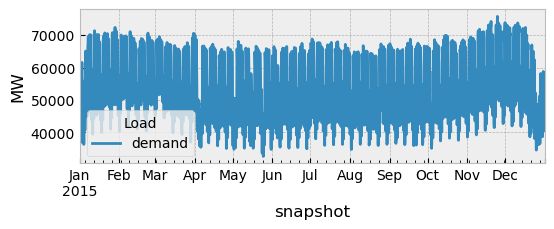

In [298]:
n.loads_t.p_set.plot(figsize=(6,2), ylabel="MW")

We are going to add one dispatchable generation technology to the model. This is an open-cycle gas turbine (OCGT) with CO$_2$ emissions of 0.2 t/MWh$_{th}$.

In [299]:
n.add(
    "Generator",
    "OCGT",
    bus='electricity',
    carrier="OCGT",
    capital_cost=costs.at["OCGT", "capital_cost"],
    marginal_cost=costs.at["OCGT", "marginal_cost"],
    efficiency=costs.at["OCGT", "efficiency"],
    p_nom_extendable=True,
)

Adding the variable renewable generators works almost identically, but we also need to supply the capacity factors to the model via the attribute `p_max_pu`.

In [300]:
for tech in ["onwind", "offwind", "solar"]:
    n.add(
        "Generator",
        tech,
        bus='electricity',
        carrier=tech,
        p_max_pu=ts[tech],
        capital_cost=costs.at[tech, "capital_cost"],
        marginal_cost=costs.at[tech, "marginal_cost"],
        efficiency=costs.at[tech, "efficiency"],
        p_nom_extendable=True,
    )

So let's make sure the capacity factors are read-in correctly.

<AxesSubplot:xlabel='snapshot', ylabel='CF'>

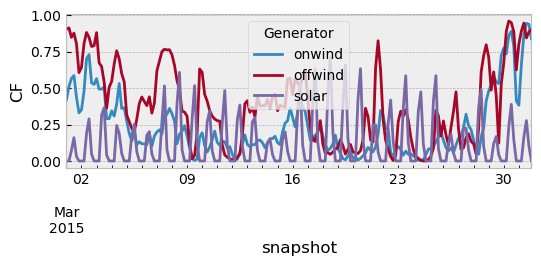

In [301]:
n.generators_t.p_max_pu.loc["2015-03"].plot(figsize=(6,2), ylabel="CF")

### Model Run

Then, we can already solve the model for the first time. At this stage, the model does not have any storage or emission limits implemented. It's going to look for the least-cost combination of variable renewables and the gas turbine to supply demand.

In [302]:
n.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.2s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /tmp/pypsa-problem-yq_dtabd.lp
Reading time = 0.03 seconds
obj: 19710 rows, 8765 columns, 33990 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: AMD Ryzen 7 PRO 4750U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 19710 rows, 8765 columns and 33990 nonzeros
Model fingerprint: 0x692d5da7
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [4e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 8e+04]
Presolve removed 9810 rows and 1051 columns
Presolve time: 0.01s
Presolved: 9900 rows, 7714 columns, 23130 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.542e+04
 Factor NZ  : 6.301e+04 (roughly 8 MB of memory)
 Factor Ops : 4.230e+05 (less than 1 s

INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e+10


('ok', 'optimal')

### Model Evaluation

The total system cost in billion Euros per year:

In [303]:
n.objective / 1e9

27.532289225227498

The optimised capacities in GW:

In [304]:
n.generators.p_nom_opt.div(1e3) # GW

Generator
OCGT       70.182246
onwind      0.000000
offwind    42.399533
solar      82.323420
Name: p_nom_opt, dtype: float64

The total energy generation by technology in GW:

In [305]:
n.snapshot_weightings.generators @ n.generators_t.p.div(1e6) # TWh

Generator
OCGT       258.400419
onwind       0.000000
offwind    131.445301
solar       89.080020
Name: generators, dtype: float64

While we get the objective value through `n.objective`, in many cases we want to know how the costs are distributed across the technologies

In [306]:
opex = n.snapshot_weightings.generators @ (n.generators_t.p * n.generators.marginal_cost).div(1e6) # M€/a

In [307]:
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6) # M€/a

In [308]:
capex + opex

Generator
OCGT       16995.624249
onwind         0.000000
offwind     6707.003079
solar       3829.661896
dtype: float64

If you have the newest version of PyPSA installed, you can also run the following to determine the total system cost by technology:

In [309]:
(n.statistics.capex() + n.statistics.opex(aggregate_time='sum')).div(1e6)

           carrier
Generator  OCGT       16995.624249
           offwind     6707.003079
           onwind         0.000000
           solar       3829.661896
dtype: float64

Possibly, we are also interested in the total emissions:

In [310]:
emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h

In [311]:
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

126.04898508063908

### Plotting Optimal Dispatch

This function takes the network object `n` as an argument and, optionally, a time frame. We want to plot the load time series, and stacked area charts for electricity feed-in and storage charging. Technologies should be coloured by their color defined in `n.carriers`.

In [312]:
def plot_dispatch(n, time="2015-07"):
    
    p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().div(1e3)
    
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.groupby(n.storage_units.carrier, axis=1).sum().div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
    
    fig, ax = plt.subplots(figsize=(6, 3))
    
    color = p_by_carrier.columns.map(n.carriers.color)
    
    p_by_carrier.where(p_by_carrier>0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=color,
    )
    
    charge = p_by_carrier.where(p_by_carrier<0).dropna(how='all', axis=1).loc[time]
    
    if not charge.empty:

        charge.plot.area(
            ax=ax,
            linewidth=0,
            color=charge.columns.map(n.carriers.color),
        )
    
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c='k')

    plt.legend(loc=(1.05,0))
    ax.set_ylabel("GW")
    ax.set_ylim(-200, 200)

Oje, that was complicated. Let's test it:

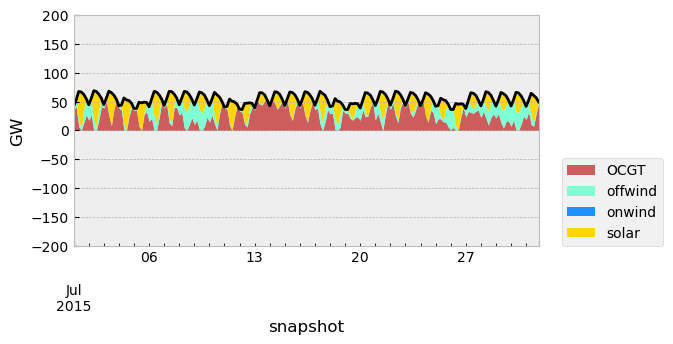

In [313]:
plot_dispatch(n)

## Adding Storage Units

Alright, but there are a few important components missing for a system with high shares of renewables? What about short-term storage options (e.g. batteries) and long-term storage options (e.g. hydrogen storage)? Let's add them too.

First, the battery storage. We are going to assume a fixed energy-to-power ratio of 6 hours, i.e. if fully charged, the battery can discharge at full capacity for 6 hours.
For the capital cost, we have to factor in both the capacity and energy cost of the storage. We are also going to enforce a cyclic state-of-charge condition, i.e. the state of charge
at the beginning of the optimisation period must equal the final state of charge.

In [314]:
n.add(
    "StorageUnit",
    "battery storage",
    bus='electricity',
    carrier="battery storage",
    max_hours=6,
    capital_cost=costs.at["battery inverter", "capital_cost"] + 6 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Second, the hydrogen storage. This one is composed of an electrolysis to convert electricity to hydrogen, a fuel cell to re-convert hydrogen to electricity and underground storage (e.g. in salt caverns). We assume an energy-to-power ratio of 168 hours, such that this type of storage can be used for weekly balancing.

In [315]:
capital_costs = (
    costs.at["electrolysis", "capital_cost"] +
    costs.at["fuel cell", "capital_cost"] +
    168 * costs.at["hydrogen storage underground", "capital_cost"]
)

n.add(
    "StorageUnit",
    "hydrogen storage underground",
    bus="electricity",
    carrier="hydrogen storage underground",
    max_hours=168,
    capital_cost=capital_costs,
    efficiency_store=costs.at["electrolysis", "efficiency"],
    efficiency_dispatch=costs.at["fuel cell", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Ok, lets run the again, now with storage, and see what's changed.

In [316]:
n.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.35s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /tmp/pypsa-problem-n__x3qgc.lp
Reading time = 0.07 seconds
obj: 50370 rows, 21907 columns, 99690 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: AMD Ryzen 7 PRO 4750U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 50370 rows, 21907 columns and 99690 nonzeros
Model fingerprint: 0xfabf6dc5
Coefficient statistics:
  Matrix range     [1e-04, 2e+02]
  Objective range  [4e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 8e+04]
Presolve removed 22950 rows and 1051 columns
Presolve time: 0.04s
Presolved: 27420 rows, 20856 columns, 75690 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 6.360e+04
 Factor NZ  : 4.597e+05 (roughly 23 MB of memory)
 Factor Ops : 8.066e+06 (less th

INFO:pypsa.linopf:Optimization successful. Objective value: 2.75e+10


('ok', 'optimal')

In [317]:
n.generators.p_nom_opt # MW

Generator
OCGT       70182.245794
onwind         0.000000
offwind    42399.532710
solar      82323.420397
Name: p_nom_opt, dtype: float64

In [318]:
n.storage_units.p_nom_opt # MW

StorageUnit
battery storage                 0.0
hydrogen storage underground    0.0
Name: p_nom_opt, dtype: float64

**Nothing!** The objective value is the same, and no storage is built.

### Adding emission limits

The gas power plant offers sufficient and cheap enough backup capacity to run in periods of low wind and solar generation. But what happens if this source of flexibility disappears. Let's model a 100% renewable electricity system by adding a CO$_2$ emission limit as global constraint:

In [319]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=0,
)

When we run the model now...

In [320]:
n.lopf(solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.31s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file /tmp/pypsa-problem-jq3j7msx.lp
Reading time = 0.07 seconds
obj: 50371 rows, 21907 columns, 101880 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: AMD Ryzen 7 PRO 4750U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 50371 rows, 21907 columns and 101880 nonzeros
Model fingerprint: 0xb3351325
Coefficient statistics:
  Matrix range     [1e-04, 2e+02]
  Objective range  [4e-02, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 8e+04]
Presolve removed 25141 rows and 3242 columns
Presolve time: 0.04s
Presolved: 25230 rows, 18665 columns, 69120 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 5.922e+04
 Factor NZ  : 3.852e+05 (roughly 20 MB of memory)
 Factor Ops : 6.160e+06 (less 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.58e+10


('ok', 'optimal')

...and inspect the capacities built...

In [321]:
n.generators.p_nom_opt # MW

Generator
OCGT            0.000000
onwind     225963.169630
offwind     76925.170810
solar      248437.267074
Name: p_nom_opt, dtype: float64

In [322]:
n.storage_units.p_nom_opt # MW

StorageUnit
battery storage                 34106.689925
hydrogen storage underground    60603.642626
Name: p_nom_opt, dtype: float64

In [323]:
n.storage_units.p_nom_opt.div(1e3) * n.storage_units.max_hours # GWh

StorageUnit
battery storage                   204.640140
hydrogen storage underground    10181.411961
dtype: float64

... we see quite a bit of storage. So how does the optimised dispatch of the system look like?

/home/fneum/miniconda3/envs/pypsa-eur-221227/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1594: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



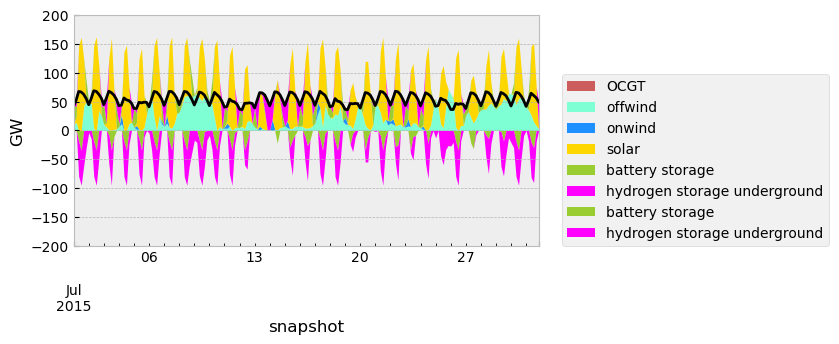

In [324]:
plot_dispatch(n)

We are also keen to see what technologies constitute the largest cost components. For that we're going to define a small helper function:

In [325]:
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex(aggregate_time='sum')
    return tsc.droplevel(0).div(1e6) # million €/a

:::{note}
If you have an older PyPSA version, the statistics accessor might not be available and you may have to use this alternative, more complicated function with individual items for each cost component:

```
def system_cost(n)
    opex = n.snapshot_weightings.generators @ (n.generators.marginal_cost * n.generators_t.p).div(1e6) # M€/a
    capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6) # M€/a
    capex_storage = (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6) # M€/a
    return pd.concat([opex, capex, capex_storage], axis=1).sum(axis=1)
```
:::

In [326]:
system_cost(n)

carrier
battery storage                  3289.077316
hydrogen storage underground    16994.853540
OCGT                                0.000000
offwind                         12168.412459
onwind                          21803.629879
solar                           11557.207204
dtype: float64

This series, we can then process into plots, e.g. a pie chart:

<AxesSubplot:>

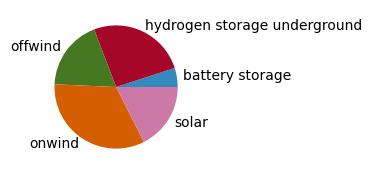

In [327]:
system_cost(n).plot.pie(figsize=(2,2))

or use to compute the cost per unit of electricity consumed:

In [328]:
demand = n.snapshot_weightings.generators @ n.loads_t.p_set.sum(axis=1)

In [329]:
system_cost(n).sum()*1e6 / demand.sum()

137.41834046865426

:::{warning}
Always consider, that the load data is given in units of power (MW) and if your resolution is not hourly, you need to multiply by the snapshot weighting to get the energy consumed!
:::

## Sensitivity Analysis

Sensitivity analyses constitute a core activity of energy system modelling. Below, you can find sensitivity analyses regarding the

1. variation in allowed CO$_2$ emissions
2. variation in solar overnight costs
3. variation in offshore wind potentials

In [275]:
sensitivity = {}
for co2 in [150,100,50,25,0]:
    n.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    n.lopf(solver_name='cbc')
    sensitivity[co2] = system_cost(n)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.91s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.76e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.93s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.80e+10
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.93s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(sensitivity).T.div(1e3) # billion Euro/a
df.plot.area(
    stacked=True,
    linewidth=0,
    color=df.columns.map(n.carriers.color),
    figsize=(4,4),
    xlim=(0,150),
    xlabel=r"CO$_2$ emissions [Mt/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0,100),
)
plt.legend(frameon=False, loc=(1.05, 0))

## Exercises

Explore the model by changing the assumptions and available technologies. Here are a few inspirations:

- Rerun the model with cost assumptions for 2050.
- What if either hydrogen or battery storage cannot be expanded?
- What if you can either only build solar or only build wind?
- What if we had a flat electricity demand profile (like in [model.energy](https://model.energy), i.e. average the demand time series)?
- Vary the energy-to-power ratio of the hydrogen storage. What ratio leads to lowest costs?
- How bad is the 4-hourly resolution used for demonstration? How does it compare to hourly or 2-hourly resolution?
- On [model.energy](https://model.energy), you can download capacity factors for onshore wind and solar for any region in the world. Drop offshore wind from the model and use the onshore wind and solar prices from another region of the world. Try a few. What changes?
- Add nuclear as another dispatchable low-emission generation technology (similar to OCGT). Perform a sensitivity analysis trying to answer how low the capital cost of a nuclear plant would need to be to be chosen.